In [1]:
import pandas as pd

# Cargar los datasets
insurance_data = pd.read_csv('insurance_data.csv')
vehicle_info = pd.read_csv('vehicle_info.csv')

In [13]:
# Unir los datasets usando la clave común (por ejemplo, 'VEHICLE_ID')
merged_data = pd.merge(insurance_data, vehicle_info, on='VEHICLE_ID')

In [2]:
# Inspeccionar los primeros registros
print(insurance_data.head())
print(vehicle_info.head())

   POLICY_ID INSR_BEGIN   INSR_END  CUSTOMER_SENIORITY     SEX  INSR_TYPE  \
0  300226657  01-JUL-14  30-JUN-15                  16  Female       1201   
1  300231460  01-JUL-14  30-JUN-15                   1  Female       1202   
2  300046799  01-JUL-14  30-JUN-15                   7  Female       1201   
3  300046807  01-JUL-14  30-JUN-15                   0  Female       1201   
4  300046812  01-JUL-14  30-JUN-15                   1  Female       1202   

   INSURED_VALUE   PREMIUM  VEHICLE_ID        USAGE  CLAIM_PAID  
0        17000.0    163.20  5000546971      Private         NaN  
1      2600000.0  45761.90  5000578640  Own service    30981.20  
2        80000.0    907.20  5000059976      Private         NaN  
3       225000.0   3690.55  5000059986      Private         NaN  
4       950000.0  10441.89  5000059996    Own Goods  2167218.69  
   VEHICLE_ID  PROD_YEAR  SEATS_NUM  CARRYING_CAPACITY TYPE_VEHICLE  CCM_TON  \
0  5000029885     2007.0        4.0                6.0      P

In [17]:
# Descripción estadística
print(insurance_data.describe())
print(vehicle_info.describe())

# Comprobar valores nulos
print(insurance_data.isnull().sum())
print(vehicle_info.isnull().sum())

          POLICY_ID  CUSTOMER_SENIORITY      INSR_TYPE  INSURED_VALUE  \
count  4.064480e+05       406448.000000  406448.000000   4.064480e+05   
mean   3.002331e+08            4.879980    1201.754648   5.766348e+05   
std    1.373768e+05            6.390458       0.431496   9.389056e+05   
min    3.000000e+08            0.000000    1201.000000   0.000000e+00   
25%    3.001141e+08            1.000000    1202.000000   0.000000e+00   
50%    3.002322e+08            2.000000    1202.000000   2.300000e+05   
75%    3.003488e+08            7.000000    1202.000000   8.500000e+05   
max    3.005081e+08           63.000000    1204.000000   6.782439e+07   

            PREMIUM    VEHICLE_ID    CLAIM_PAID  
count  4.064390e+05  4.064480e+05  3.304000e+04  
mean   8.071209e+03  5.000525e+09  2.459209e+05  
std    1.633394e+04  3.313397e+05  1.102638e+06  
min    0.000000e+00  5.000018e+09  0.000000e+00  
25%    7.371500e+02  5.000195e+09  1.490000e+04  
50%    3.837930e+03  5.000567e+09  3.69276

Podemos realizar varias observaciones a partir del análisis descriptivo:

- Hay un promedio de antigüedad de aprox. 5 años (parecería haber algunos outliers ya que el valor máximo es de 63 años)
- Hay un promedio del valor asegurado de 576 635 pero con cuartiles muy diferentes entre sí.
- En el promedio de la capacidad de carga vemos que está muy distorcionado por los camiones que pueden llevar mucho peso (promedio de 415 mientras que para el 75% superior es de 11).
- A priori, tiene sentido que hayan 373 408 valores nulos para "CLAIM_PAID" (no hubo reclamos), 49 109 para "CARRYING_CAPACITY" (vehículos sin capacidad de carga) y pocos para el resto de las variables.

## Visualización de datos

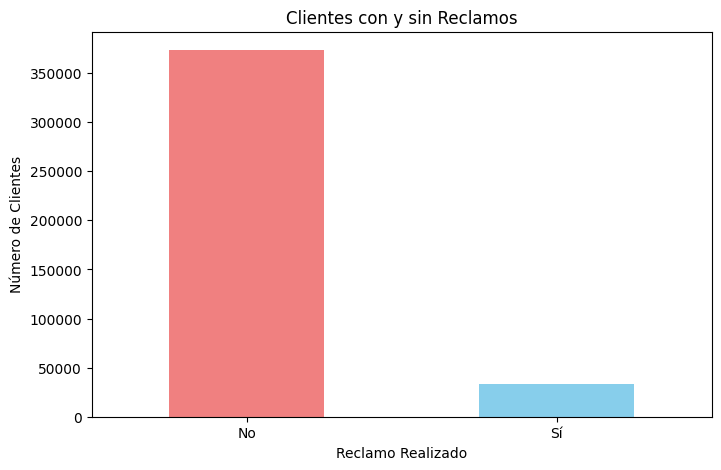

In [28]:
# Crear una columna que indique si hubo reclamo
merged_data['CLAIM_MADE'] = merged_data['CLAIM_PAID'].notna()

# Contar el número de clientes con y sin reclamos
claim_counts = merged_data['CLAIM_MADE'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
claim_counts.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Clientes con y sin Reclamos')
plt.xlabel('Reclamo Realizado')
plt.ylabel('Número de Clientes')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.show()

Hay una diferencia enorme entre clientes que realizaron un reclamo y los que no, esto puede llegar antraer problemas de balanceo entre clases en la predicción a realizar.

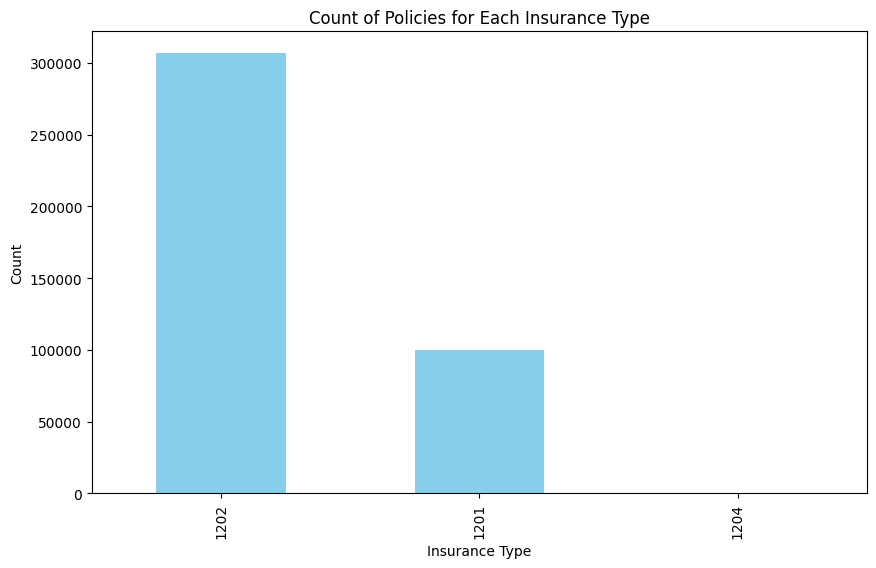

In [9]:
# Contar el número de pólizas para cada tipo de seguro
insr_type_counts = insurance_data['INSR_TYPE'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
insr_type_counts.plot(kind='bar', color='skyblue')

# Configuración del gráfico
plt.title('Count of Policies for Each Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Count')

# Mostrar el gráfico
plt.show()

Hay el triple de pólizas del tipo 1202 que del tipo 1201.

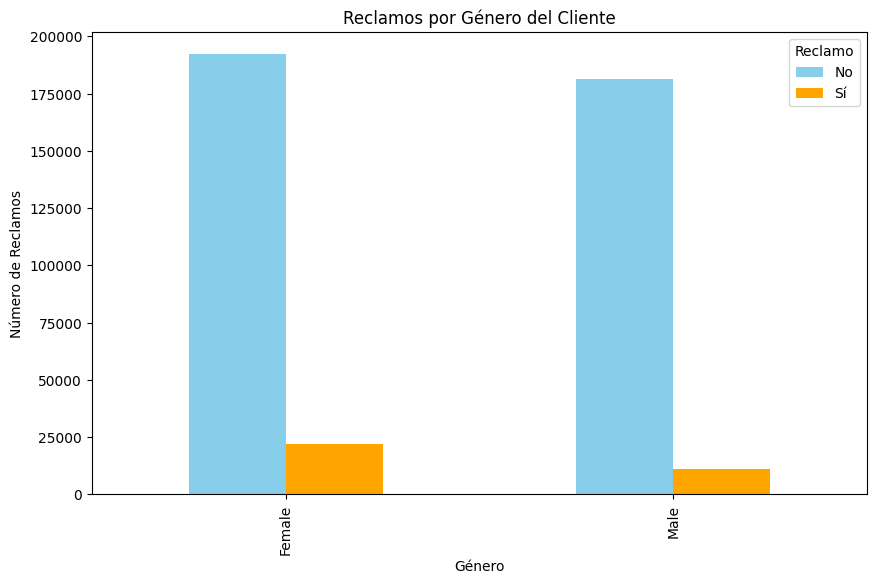

In [25]:
# Crear una columna booleana para si el reclamo fue pagado (ajusta según tus datos)
insurance_data['CLAIM_PAID_BIN'] = insurance_data['CLAIM_PAID'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Crear una tabla cruzada para contar reclamos por género y si se pagó el reclamo
claim_counts = pd.crosstab(insurance_data['SEX'], insurance_data['CLAIM_PAID_BIN'])

# Crear el gráfico de barras agrupadas
claim_counts.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])

# Configuración del gráfico
plt.title('Reclamos por Género del Cliente')
plt.xlabel('Género')
plt.ylabel('Número de Reclamos')
plt.legend(title='Reclamo', labels=['No', 'Sí'])

# Mostrar el gráfico
plt.show()


Podemos observar que hay mayor cantidad de reclamos de pago por parte de mujeres que de hombres (esto no significa necesariamente que el monto total sea superior).

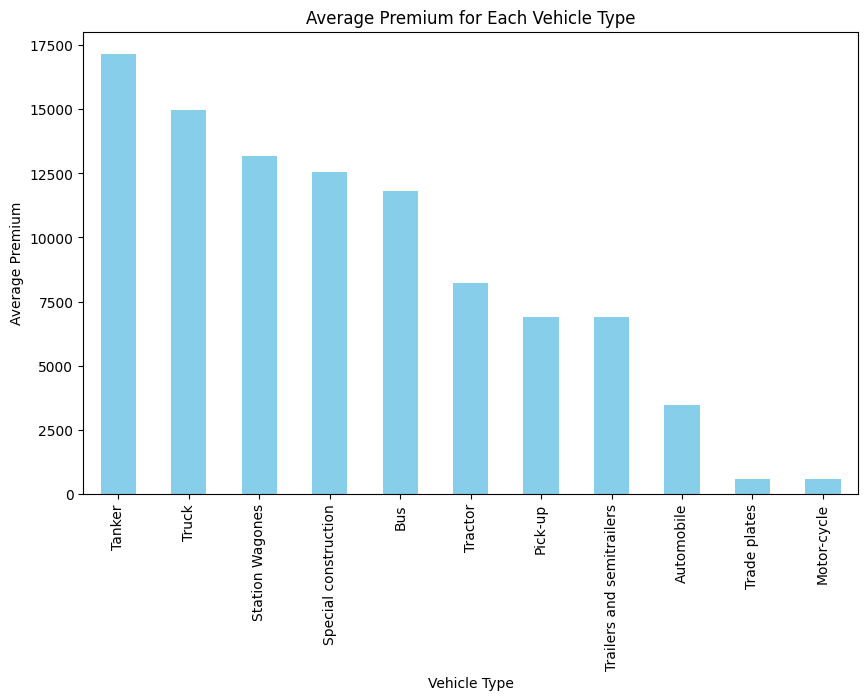

In [20]:
# Calcular la prima promedio para cada tipo de vehículo
avg_premium_by_vehicle = merged_data.groupby('TYPE_VEHICLE')['PREMIUM'].mean()

# Ordenar de mayor a menor
avg_premium_by_vehicle = avg_premium_by_vehicle.sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
avg_premium_by_vehicle.plot(kind='bar', color='skyblue')

# Configuración del gráfico
plt.title('Average Premium for Each Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Premium')

# Mostrar el gráfico
plt.show()

Parece que cuanto mayor tamaño y peso que soporta el vehículo, mayor es la cuota que paga. Esto tiene sentido ya que tiene mayor valor.

In [33]:
# Convertir las columnas de fecha a tipo datetime
insurance_data['INSR_BEGIN'] = pd.to_datetime(insurance_data['INSR_BEGIN'])
insurance_data['INSR_END'] = pd.to_datetime(insurance_data['INSR_END'])

# Calcular la duración de la póliza en días
insurance_data['POLICY_DURATION_DAYS'] = (insurance_data['INSR_END'] - insurance_data['INSR_BEGIN']).dt.days


In [42]:
# Contar el número de pólizas por duración
duration_counts = insurance_data['POLICY_DURATION_DAYS'].value_counts().reset_index()
duration_counts.columns = ['POLICY_DURATION_DAYS', 'COUNT']

# Calcular el porcentaje (share) de cada duración
duration_counts['SHARE'] = (duration_counts['COUNT'] / duration_counts['COUNT'].sum()) * 100

# Ordenar por SHARE en orden descendente
duration_counts_sorted = duration_counts.sort_values(by='SHARE', ascending=False).reset_index(drop=True)

# Mostrar la tabla
print(duration_counts_sorted)

     POLICY_DURATION_DAYS   COUNT      SHARE
0                     364  279832  68.848168
1                     365  110303  27.138281
2                     182    2535   0.623696
3                     183    2149   0.528727
4                     265    1339   0.329439
..                    ...     ...        ...
324                    79       1   0.000246
325                   133       1   0.000246
326                   293       1   0.000246
327                    42       1   0.000246
328                   101       1   0.000246

[329 rows x 3 columns]


Podemos observar que la gran mayoría de pólizas duran 1 año. No tiene sentido utilizar la duración como variable explicativa para nuestro modelo de predicción.